In [2]:
import numpy as np
from tqdm import tqdm
from scipy import stats
from scipy.optimize import minimize
import pyfrechet.metric_spaces.wasserstein_1d as W1d
from pyfrechet.metric_spaces import MetricData
from pyfrechet.metric_spaces import log_cholesky

# todo: change the order of the arguments
def geodesic(x, theta, mu):
    return theta * x + (1-theta)*mu

def iter_log_cholesky(T, phi):
    M = log_cholesky.LogCholesky(10)

    def log_chol_to_L(DL):
        n = DL.shape[0]
        d = int((-1 + np.sqrt(1 + 8 * n)) / 2)
        L = np.zeros(shape=(d,d))
        L[np.diag_indices(d)] = np.exp(DL[:d])
        L[np.tril_indices(d, -1)] = DL[d:]
        return L

    def noise(x):
        C_eps = np.zeros_like(x)
        C_eps[:M.dim] = .12 * np.random.normal(size=M.dim)
        C_eps[M.dim:] = .25 * np.random.normal(size=x.shape[0] - M.dim)
        
        L_eps = log_chol_to_L(C_eps)
        x = log_cholesky.log_chol_to_spd(x)
        return log_cholesky.spd_to_log_chol(L_eps.dot(x).dot(L_eps.T))

    def sim(T, phi, mu):
        x = np.zeros((T, mu.shape[0])) + mu
        for i in range(1,T):
            x[i, :] = noise(geodesic(x[i-1], phi, mu))
        return x
    
    def phi_hat(x, tol=None):
        mu_hat = MetricData(M, x).frechet_mean()
        T = x.shape[0]
        tol = tol or min(1.0 / T, 1e-4)
        def L(phi): return np.array([ M._d(x[j+1,:], geodesic(x[j,:], phi, mu_hat))**2 for j in range(T-1) ]).mean()
        # return minimize(L, np.random.rand(), method='Nelder-Mead', bounds=[(0,1)], options=dict(xatol=tol))['x'][0]
        return minimize(L, np.random.rand(), method='BFGS')['x'][0]

    mean = log_cholesky.spd_to_log_chol(np.eye(M.dim))
    return phi_hat(sim(T, phi, mean))

def iter_wasserstein(T, phi):
    W = W1d.Wasserstein1D()

    def sim(T, phi, mu):
        x = np.zeros((T, mu.shape[0])) + mu
        for i in range(1,T):
            z = geodesic(x[i-1], phi, mu)
            k = (1 - 2*np.random.binomial(1,0.5)) * np.random.randint(1, 5)
            x[i, :] = z - np.sin(np.pi*k*z)/np.pi/abs(k)
        return x
    
    def phi_hat(x, tol=None):
        mu_hat = MetricData(W, x).frechet_mean()
        T = x.shape[0]
        tol = tol or min(1.0 / T, 1e-8)
        def L(phi): return np.array([ W._d(x[j+1,:], geodesic(x[j,:], phi, mu_hat))**2 for j in range(T-1) ]).mean()
        return minimize(L, np.random.rand(), method='BFGS')['x'][0]

    STD_NORMAL_Q = stats.norm.ppf(W1d.Wasserstein1D.GRID)
    STD_NORMAL_Q[0] = 2*STD_NORMAL_Q[1] - STD_NORMAL_Q[2] # lexp to avoid infs
    STD_NORMAL_Q[-1] = 2*STD_NORMAL_Q[-2] - STD_NORMAL_Q[-3] # lexp to avoid infs
    mean = STD_NORMAL_Q

    return phi_hat(sim(T, phi, mean))

def iter_r(T, phi):
    def sim(T, phi, mu):
        sig = 0.2
        x = np.zeros((T,1)) + mu
        for i in range(1,T):
            x[i] = (1 + sig*np.random.randn())* geodesic(x[i-1], phi, mu)
        return x
    
    def phi_hat(x, tol=None):
        T = x.shape[0]
        tol = tol or min(1.0 / T, 1e-5)
        mu_hat = x.mean()
        def L(phi): return np.array([ (x[j+1] - geodesic(x[j], phi, mu_hat))**2 for j in range(T-1) ]).mean()
        # return minimize(L, np.random.rand(), method='Nelder-Mead', bounds=[(0,1)], options=dict(xatol=tol))['x'][0]
        return minimize(L, np.random.rand(), method='BFGS')['x'][0]

    mean = 1.5
    x = sim(T, phi, mean)
    return phi_hat(x)


results_3 = []
errs = []
for i in tqdm(range(250)):
    for sample_size in [20, 40, 80, 160, 320, 640]:
        for phi in [0, 0.1, 0.2, 0.3, 0.4, 0.5, 1]:
            # o_r = iter_r(sample_size, phi)
            # o_w = iter_wasserstein(sample_size, phi)
            try:
                o_lc = iter_log_cholesky(sample_size, phi)
                results_3.append((sample_size, phi, i, o_lc))
            except:
                errs.append((sample_size, phi))
                
            

INFO: Using numpy backend
100%|██████████| 250/250 [05:29<00:00,  1.32s/it]


In [170]:
len(results_3), len(errs), len(errs)/len(results_3)

(9857, 643, 0.06523282946129653)

Text(0, 0.5, '$\\left|\\hat\\varphi - \\varphi\\right|$')

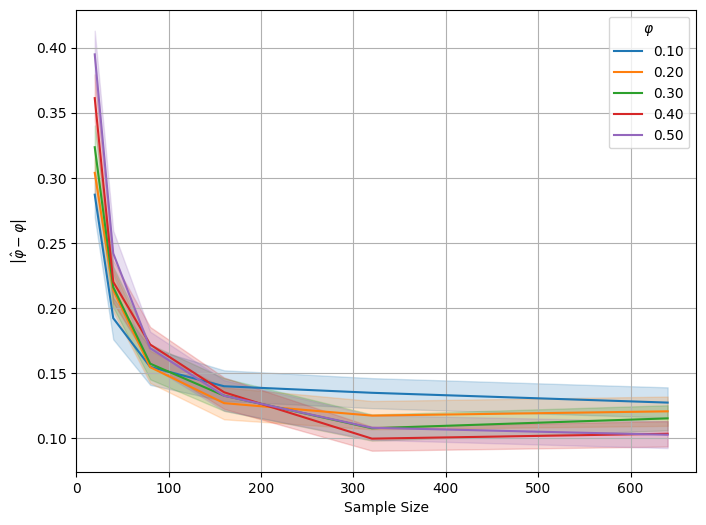

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


# _df = pd.DataFrame(results_3, columns=['sample_size', 'phi', 'i', 'phi_r', 'phi_ws'])
_df = pd.DataFrame(results_3, columns=['sample_size', 'phi', 'i', 'phi_hat'])


f, ax = plt.subplots(figsize=(8,6))
# ax.set(xscale="log", yscale="log")

for phi in np.sort(_df.phi.unique()):
    if phi == 0 or phi == 1:
        # ax.plot([], [], label=r'$0\ (H_0)$')
        continue
    sub_df = _df[_df['phi'] == phi].copy()
    # sub_df['err_phi_r'] =  np.sqrt(sub_df['sample_size']) * np.abs(sub_df['phi_r'] - phi)
    # sub_df['err_phi_ws'] =  np.sqrt(sub_df['sample_size']) * np.abs(sub_df['phi_ws'] - phi)
    sub_df['err_phi'] =  np.power(sub_df['sample_size'], 0.5) * np.abs(sub_df['phi_hat'] - phi)

    label = r'$0\ (H_0)$' if phi == 0 else f'{phi:.2f}'
    sns.lineplot(sub_df, x='sample_size', y='err_phi', label=label, ax=ax)
    # sns.lineplot(sub_df, x='sample_size', y='err_phi_ws', label=label, ax=ax)
    # sns.lineplot(sub_df, x='sample_size', y='err_phi_ws', label='opt', ax=ax)

plt.legend(title=r'$\varphi$')
plt.grid(True)
plt.xlim(0)
plt.xlabel('Sample Size')
plt.ylabel(r'$\left|\hat\varphi - \varphi\right|$')